In [2]:
import pandas as pd
import trackpy as tp
import os
import numpy as np

from __future__ import division  # this makes mathematical division work better
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
fps = 12.005
scaling = 150.0/1182.0  # Macgruberscope 60x1.0

In [3]:
myhome = '/home/viva'
directory = 'group/viva/Analysis/2016-02-18/data_taken_2016-01-26,_movie01_60x1.0_Hematite_swimmers_without_Lumencor'
filename = 't1.pkl'
t1 = pd.read_pickle(os.path.join(myhome, directory,filename))
moviename = 'particles without activation'
t1.head()

,x,y,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
0,1209.431156,15.426450,3357.034733,3.547894,0.075422,55.249444,-9256.5,0.018160,0,0
1,1212.580591,15.855655,3396.509926,3.563892,0.076532,57.639448,-9247.5,0.018972,1,0
2,1211.581648,15.306759,3463.805549,3.614986,0.070971,55.954434,-9081.5,0.017812,2,0
3,1211.551796,14.504956,3472.893367,3.564437,0.060061,57.840242,-9068.0,0.017938,3,0
4,1211.832442,12.549335,3532.532966,3.566978,0.076925,58.816001,-9016.0,0.017156,4,0


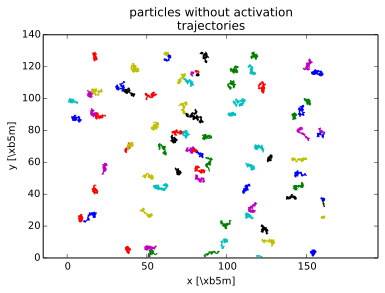

In [4]:
try:
    axes().set_aspect('equal', 'datalim') 
except:
    pass
plt.title(moviename + '\ntrajectories')
trajectory_plot = tp.plot_traj(t1, mpp = scaling, label=False)

In [5]:
imsd = tp.imsd(t1, scaling, fps, max_lagtime=1000)

/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


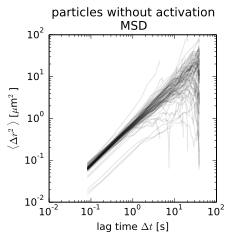

In [6]:
fig, ax = plt.subplots()
ax.plot(imsd.index, imsd, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $\Delta{}t$ [s]')
ax.set_xscale('log')
ax.set_yscale('log')
fig.set_size_inches(3,3)
plt.title(moviename + '\nMSD')

In [7]:
emsd = tp.emsd(t1, scaling, fps,max_lagtime=100)

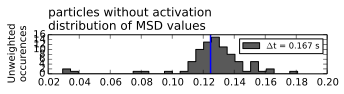

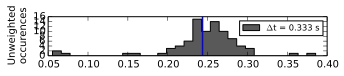

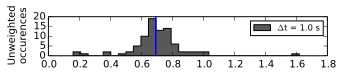

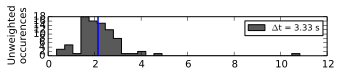

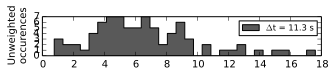

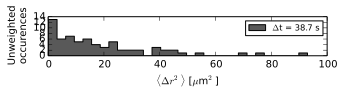

In [8]:
# I wonder whether these datapoints are normally distributed.

first = True
for i in np.logspace(0,log(len(imsd)-1)/log(10),num=6, dtype=int, base=10):
    #print i
    fig = figure(figsize=[5,.7])
       
    # plot a histogram of the MSD values for a single lag time
    imsd.iloc[i].hist(bins=30, grid = False, histtype='stepfilled', color='.35'
                               ,label=r'$\Delta$t = {:.3} s'.format(imsd.index[i]))
    
    try:
        # plot a vertical line showing the ensemble mean square displacement for a single lag time
        axvline(x=emsd.iloc[i], color='b', linewidth=1.5)
           #,label='mean {:.2}'.format(emsd_zero_perox.iloc[i]))
    except IndexError:
        pass
    
    if first:
        plt.title(moviename + '\ndistribution of MSD values', loc='left') 
        first = False
    plt.ylabel('Unweighted\noccurences')
    plt.legend(frameon=True, fontsize='small', markerscale= 1)

plt.xlabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')

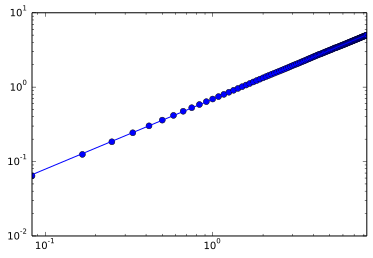

,n,A
msd,0.94026,0.689572


In [9]:
res = tp.utils.fit_powerlaw(emsd)  # performs linear best fit in log space, plots
res

In [10]:
t0 = frange(.0666,10,.1)
fit = res.A[0]*(t0**res.n[0])

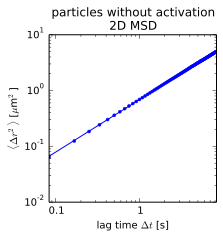

In [11]:
ax =emsd.plot(loglog=True, style='b.',linewidth=.3, grid=False, figsize = [3,3], label="emsd")

# plot fit
loglog(t0,fit, 'b')

ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $\Delta t$ [s]')
#ax.set_xticks([.1,1,10])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))

plt.title(moviename + "\n2D MSD")

#savefig('/home/viva/group/viva/Analysis/2016-03-02/MSD_of_tracers_in_droplets_containing_both_tracers_and_Janus_particles.pdf')
#savefig('/home/viva/group/viva/Analysis/2016-03-02/MSD_of_tracers_in_droplets_containing_both_tracers_and_Janus_particles.png')

In [12]:
# A new version of tp.motion.emsd() that calculates standard deviation.
# This function is copied from trackpy. (Please see the trackpy license.)
# I [Viva] added the calculation of biased weighted standard deviation.

def my_emsd(traj, mpp, fps, max_lagtime=100, detail=False, pos_columns=None):
    """Compute the ensemble mean squared displacements of many particles.

    Parameters
    ----------
    traj : DataFrame of trajectories of multiple particles, including
        columns particle, frame, x, and y
    mpp : microns per pixel
    fps : frames per second
    max_lagtime : intervals of frames out to which MSD is computed
        Default: 100
    detail : Set to True to include <x>, <y>, <x^2>, <y^2>. Returns
        only <r^2> by default.

    Returns
    -------
    Series[msd, index=t] or, if detail=True,
    DataFrame([<x>, <y>, <x^2>, <y^2>, msd, N, lagt,
               std_<x>, std_<y>, std_<x^2>, std_<y^2>, 
               std_msd],
              index=frame)

    Notes
    -----
    Input units are pixels and frames. Output units are microns and seconds.
    """
    ids = []
    msds = []
    for pid, ptraj in traj.reset_index(drop=True).groupby('particle'):
        msds.append(tp.motion.msd(ptraj, mpp, fps, max_lagtime, True, pos_columns))
        ids.append(pid)
    msds = pd.concat(msds, keys=ids, names=['particle', 'frame'])
    results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
    results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized
    # Above, lagt is lumped in with the rest for simplicity and speed.
    # Here, rebuild it from the frame index.
    
    if not detail:
        return results.set_index('lagt')['msd']

    # Calculation of biased weighted standard deviation
    numerator = ((msds.subtract(results))**2).mul(msds['N'], axis=0).sum(level=1)
    denominator = msds['N'].sum(level=1) # without Bessel's correction
    variance = numerator.div(denominator, axis=0)
    variance = variance[['<x>', '<y>', '<x^2>','<y^2>','msd']]
    std = np.sqrt(variance)
    std.columns = 'std_' + std.columns  

    return results.join(std)

detailed_emsd = my_emsd(t1, scaling, fps, detail=True, max_lagtime=500)

/usr/lib/pymodules/python2.7/matplotlib/collections.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


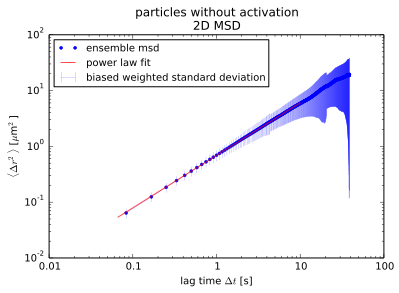

In [13]:
plt.errorbar(detailed_emsd.lagt, 
             detailed_emsd.msd, 
             yerr = detailed_emsd.std_msd, 
             capthick=0, 
             alpha = 0.7,
             linewidth=.2,
             label="biased weighted standard deviation")
loglog(detailed_emsd.lagt, detailed_emsd.msd, 'b.',  label="ensemble msd")
loglog(t0,fit, 'r', alpha=.7, label="power law fit") # plot fit

ax2 = plt.subplot(111)
ax2.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $\Delta t$ [s]')
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))

plt.title(moviename + "\n2D MSD")
plt.legend(loc=2, fontsize='medium')

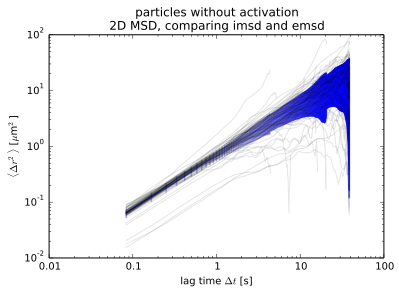

In [14]:
fig, ax = plt.subplots()

ax.plot(imsd.index, imsd, 'k-', alpha=0.1, label="MSD of each particle")
#loglog(t0,fit, 'r', alpha=.7, label="power law fit") # plot fit
plt.errorbar(detailed_emsd.lagt, detailed_emsd.msd, yerr = detailed_emsd.std_msd, capthick=0, 
             linewidth=1.5, alpha=.3,
             label="ensemble MSD with standard deviation")

ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $\Delta{}t$ [s]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
plt.title(moviename + '\n2D MSD, comparing imsd and emsd')

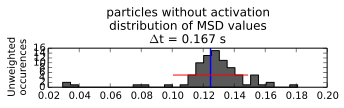

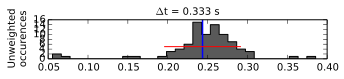

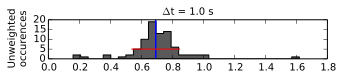

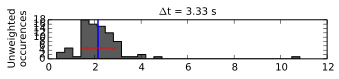

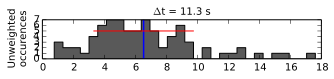

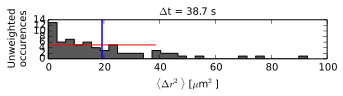

In [36]:
# I wonder whether these datapoints are normally distributed.

first = True
for i in np.logspace(0,log(len(imsd)-1)/log(10),num=6, dtype=int, base=10):
    #print i
    fig = figure(figsize=[5,.7])
       
    # plot a histogram of the MSD values for a single lag time
    imsd.iloc[i].hist(bins=30, grid = False, histtype='stepfilled', color='.35',
                      label=r'$\Delta$t = {:.3} s'.format(imsd.index[i]))
    
    # plot a blue vertical line showing the ensemble mean square displacement for a single lag time
    axvline(x=detailed_emsd.iloc[i].msd, color='b', linewidth=1.5)
           #,label='mean {:.2}'.format(emsd_zero_perox.iloc[i]))
        
    # plot a red horizontal line showing the standard deviation
    xmin = (detailed_emsd.iloc[i].msd)-(detailed_emsd.iloc[i].std_msd)
    xmax = (detailed_emsd.iloc[i].msd)+(detailed_emsd.iloc[i].std_msd)
    plot([xmin,xmax],[5,5], 'r')
    
    if first:
        plt.title(moviename + '\ndistribution of MSD values\n'+ '$\Delta$t = {:.3} s'.format(imsd.index[i])) 
        first = False
    else:
        plt.title('$\Delta$t = {:.3} s'.format(imsd.index[i]), fontdict={'fontsize':'medium'}, loc='center')
    plt.ylabel('Unweighted\noccurences')
    #plt.legend(frameon=True, fontsize='small')

plt.xlabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')

In [16]:
from scipy.optimize import curve_fit 

In [17]:
import scipy
scipy.__version__
# need at least version 14.0 of scipy.

'0.17.0'

In [18]:
def powerlaw(t, A, n):
    return (A * (t**n))

In [19]:
params, pcov = curve_fit(powerlaw, detailed_emsd.lagt, detailed_emsd.msd, 
                         #p0=[res.A[0], res.n[0]], 
                         sigma=detailed_emsd.std_msd,
                         absolute_sigma=True)

In [20]:
yfit = powerlaw(detailed_emsd.lagt,params[0],params[1])

#for y in yfit:
#    if y < 0:
#        yfit.replace(y, nan, inplace=True)

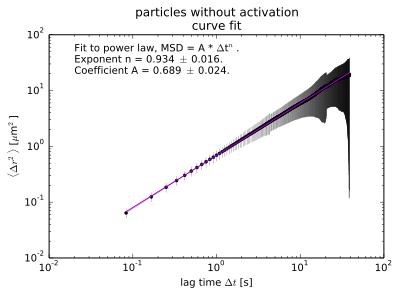

In [31]:
loglog(detailed_emsd.lagt,detailed_emsd.msd, 'k.')
loglog(detailed_emsd.lagt,yfit, 'm-')
plt.errorbar(detailed_emsd.lagt, 
             detailed_emsd.msd, 
             yerr = detailed_emsd.std_msd, 
             ecolor = 'k',
             capthick=0, 
             alpha = 0.7,
             linewidth=.3,
             label="biased weighted standard deviation")

plt.xlabel('lag time $\Delta{}t$ [s]')
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
#pylab.axes().set_aspect('equal', 'datalim')
plt.title(moviename + '\ncurve fit')

#print 'Fit to power law, MSD ~ A * $\Delta$t$^n$.'
#print 'Coefficient A = ' + str(params[0]) + ' ± ' + str(pcov[0,0])
#print 'Exponent n = ' + str(params[1]) + ' ± ' + str(pcov[1,1])

plt.text(0.02,20, 
        'Fit to power law, MSD = A * $\Delta$t$^n$.'
         + '\nExponent n = {:.3} $\pm$ {:.3f}.'.format(params[1],sqrt(pcov[1,1]))
         + '\nCoefficient A = {:.3} $\pm$ {:.3f}.'.format(params[0],sqrt(pcov[0,0])))


# The entries on the diagonal of the covariance matrix \Sigma are 
# the variances of each element of the vector \mathbf{X}.
#  source: https://en.wikipedia.org/wiki/Covariance_matrix#Generalization_of_the_variance

In [22]:
pcov

array([[ 0.00056873, -0.00028037],
       [-0.00028037,  0.0002422 ]])

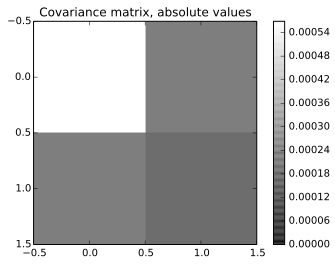

In [26]:
imshow(abs(pcov), cmap="gray", interpolation="nearest", vmin=0)
plt.colorbar()
plt.title('Covariance matrix, absolute values')

In [35]:
print  'Coefficient A = ' + str(params[0]) + ' ± ' + str(np.sqrt(pcov[0,0]))
print 'Exponent n = ' + str(params[1]) + ' ± ' + str(np.sqrt(pcov[1,1]))

Coefficient A = 0.688842879743 ± 0.0238480326888
Exponent n = 0.934072032665 ± 0.0155627467421
